In [1]:
import numpy as np
from scipy.constants import h, c, hbar, u, e
from scipy.sparse.linalg import eigsh
from scipy.sparse import diags, spdiags
from scipy.interpolate import splrep, splev
from scipy.integrate import romb, solve_ivp, odeint
from scipy.linalg import eigh
from scipy.optimize import root
import matplotlib.pyplot as plt
from matplotlib import animation
import math

def V(x, a, b, f):
    """x : Angstrom; a : eV / Angstrom^2; b : eV / Angstrom^4"""
    return f * x + a * x ** 2 + b * x ** 4

In [3]:
def fdm_constrained_dense_solver(a, b, x_exp, state=0, init_f=None, gs_coef=None, index=0,
                                 ntrial=50, eps=5e-3, bound=(-1.5, 1.5), mass=1.0, debug=False):
    """a : eV / Angstrom^2; b : eV / Angstrom^4; mass : u"""
    index=int(index)
    state = int(state)
    eps = abs(eps)
    # boundary
    if bound[1] < bound[0]:
        left = bound[1]
        right = bound[0]
    else:
        left = bound[0]
        right = bound[1]

    # number of grids
    N = int((right - left) / eps) + 1
    # make sure in the end there are 2**k + 1 points
    N = int(2 ** int(np.ceil(np.log2(N))) + 1)
    if debug:
        print(f'{N=}')
    # distance between points
    dx = float(right - left) / (N - 1)
    # x grids
    x = np.linspace(left, right, num=N)
    
    # solve for the ground state first
    diagonals = np.zeros((3, N))
    # off-diag
    diagonals[0, :] = -0.5 * hbar ** 2 * 1e20 / e / (mass * u) / dx**2
    # diag
    diagonals[1, :] = float(1) * hbar ** 2 * 1e20 / e / (mass * u) / dx**2
    # in the end this is a symmetric matrix
    diagonals[2, 1:] = diagonals[0, :-1]
    xx = np.linspace(left, right, num=int((right - left) / 1e-3)+1)
    v_plt = a * xx ** 2 + b * xx ** 4
    if state == 0:
        if init_f is None:
            init_f = 0.0
        def x_diff(f):
            # potential part
            diagonals_cp = np.copy(diagonals)
            diagonals_cp[1, :] += V(x, a, b, f)
            H = spdiags(diagonals_cp, [-1, 0, 1], N, N, format='csc')
            # solve Hc = ec
            v_f_plt = v_plt + f * xx
            ene, coef = eigsh(H, k=ntrial, sigma=v_f_plt.min(), which='LM')
            xExp = []
            true_e = []
            for i in range(ntrial):
                xExp.append(romb(x * coef[:,i] ** 2, dx=dx) / romb(coef[:,i] ** 2, dx=dx))
                true_e.append(ene[i] - f.item(0) * xExp[-1])
            xExp = np.array(xExp)
            true_e = np.array(true_e)
            idx = np.argpartition(true_e, range(state + 2))
            if debug:
                print(f'{f=}, {xExp[idx[state]] - x_exp=}') # debug
            return xExp[idx[state]] - x_exp
        sol = root(x_diff, init_f, method='df-sane', options={'fatol' : 1e-11})
        # potential part
        diagonals[1, :] += V(x, a, b, sol.x)
        H = spdiags(diagonals, [-1, 0, 1], N, N, format='csc')
        # solve Hc = ec
        v_f_plt = v_plt + sol.x * xx
        ene, coef = eigsh(H, k=ntrial, sigma=v_f_plt.min(), which='LM')
        xExp = []
        true_e = []
        for i in range(ntrial):
            xExp.append(romb(x * coef[:,i] ** 2, dx=dx) / romb(coef[:,i] ** 2, dx=dx))
            true_e.append(ene[i] - sol.x.item(0) * xExp[-1])
        xExp = np.array(xExp)
        true_e = np.array(true_e)
        idx = np.argpartition(true_e, range(3))
        return true_e[idx[0]], coef[:, idx[0]] / np.sqrt(romb(coef[:, idx[0]] ** 2, dx=dx)), \
               sol.x.item(0), xExp[idx[0]] - x_exp
    elif state == 1:
        if init_f is None:
            init_f = [0.0, 0.0]
        overlap_mat = np.outer(gs_coef, gs_coef)
        if debug:
            print(overlap_mat.shape)
        def x_diff(f):
            # potential part
            diagonals_cp = np.copy(diagonals)
            diagonals_cp[1, :] += V(x, a, b, f[0])
            H = spdiags(diagonals_cp, [-1, 0, 1], N, N, format='csc')
            # convert to a dense matrix
            H = H.toarray() + f[1] * overlap_mat
            # solve Hc = ec
            ene, coef = eigh(H, subset_by_index=[0, ntrial])
            xExp = []
            overlap = []
            true_e = []
            for i in range(ntrial):
                xExp.append(romb(x * coef[:,i] ** 2, dx=dx) / romb(coef[:,i] ** 2, dx=dx))
                overlap.append(romb(gs_coef * coef[:,i], dx=dx)**2 / romb(coef[:,i] ** 2, dx=dx))
                true_e.append(ene[i] - f[0] * xExp[-1] - f[1] * overlap[-1])
            xExp = np.array(xExp)
            overlap = np.array(overlap)
            true_e = np.array(true_e)
            idx = np.argpartition(true_e, range(3))
            if debug:
                print(f'{f[0]=}, {xExp[idx[index]] - x_exp=}') # debug
                print(f'{f[1]=}, {overlap[idx[index]]=}') # debug
            return [xExp[idx[index]] - x_exp, overlap[idx[index]]]
        sol = root(x_diff, init_f, method='df-sane', options={'fatol' : 3e-10})
        # potential part
        diagonals[1, :] += V(x, a, b, sol.x[0])
        H = spdiags(diagonals, [-1, 0, 1], N, N, format='csc')
        # convert to a dense matrix
        H = H.toarray() + sol.x[1] * overlap_mat
        # solve Hc = ec
        ene, coef = eigh(H, subset_by_index=[0, ntrial])
        xExp = []
        overlap = []
        true_e = []
        for i in range(ntrial):
            xExp.append(romb(x * coef[:,i] ** 2, dx=dx) / romb(coef[:,i] ** 2, dx=dx))
            overlap.append(romb(gs_coef * coef[:,i], dx=dx)**2 / romb(coef[:,i] ** 2, dx=dx))
            true_e.append(ene[i] - sol.x[0] * xExp[-1] - sol.x[1] * overlap[-1])
        xExp = np.array(xExp)
        overlap = np.array(overlap)
        true_e = np.array(true_e)
        idx = np.argpartition(true_e, range(3))
        return true_e[idx[index]], sol.x[0], sol.x[1], xExp[idx[index]] - x_exp, overlap[idx[index]]
    else:
        raise ValueError('Only ground state or 1st ex state are supported')

In [6]:
e_gs, c_gs, f0, error0 = fdm_constrained_dense_solver(0, 32, 0.3, init_f=0, state=0, debug=True, mass=1.0)
print(e_gs, f0, error0)
e_ex, f1, f2, error1, error2 = fdm_constrained_dense_solver(0, 32, 0.3, state=1, init_f=[-0.2,5], gs_coef=c_gs, index=0, debug=True,mass=1.0)
print(e_ex, f1, f2, error1, error2)

N=1025
f=array(0), xExp[idx[state]] - x_exp=-0.3000000000000006
f=array(0.3), xExp[idx[state]] - x_exp=-0.3589317509836391
f=array(-1.52719033), xExp[idx[state]] - x_exp=-0.10566843919601693
f=array(-2.28954453), xExp[idx[state]] - x_exp=-0.06408059479904649
f=array(-3.46421735), xExp[idx[state]] - x_exp=-0.018843430241396175
f=array(-3.95352445), xExp[idx[state]] - x_exp=-0.0036327009338677496
f=array(-4.07038316), xExp[idx[state]] - x_exp=-0.00021991943708177253
f=array(-4.07791353), xExp[idx[state]] - x_exp=-2.6222137540221624e-06
f=array(-4.0780044), xExp[idx[state]] - x_exp=-1.900832435897115e-09
0.4508869731612204 -4.078004404649249 -1.9008324914082664e-09
N=1025
(1025, 1025)
f[0]=-0.2, xExp[idx[index]] - x_exp=-0.3361686554469955
f[1]=5.0, overlap[idx[index]]=2.6829236657954063e-09
f[0]=0.13616865544699547, xExp[idx[index]] - x_exp=-0.3735921715280456
f[1]=4.999999997317076, overlap[idx[index]]=1.7818501288392377e-09
f[0]=-3.2197420429520944, xExp[idx[index]] - x_exp=-0.09497239

In [104]:
x1 = np.arange(0.0, 0.165, 0.01)
x2 = np.arange(0.18, 0.245, 0.01)
x3 = np.arange(0.26, 0.37, 0.01)
print(x1)
print(x2)
print(x3)
lines = []
f0 = 0.0
f1 = 0.0
f2 = 3.47 / 1.1
for xx in x1:
    e_gs, c_gs, f0, error0 = fdm_constrained_dense_solver(-4, 32, xx, state=0, init_f=0.0)
    e_ex, f1, f2, error1, error2 = fdm_constrained_dense_solver(-4, 32, xx, state=1, gs_coef=c_gs, init_f=[0.0, f2 * 1.1])
    lines.append([xx, e_gs, e_ex, f0, f1, f2, error0, error1, error2])
    print(lines[-1])
    
for xx in x2:
    e_gs, c_gs, f0, error0 = fdm_constrained_dense_solver(-4, 32, xx, state=0, init_f=f0 * 1.01)
    e_ex, f1, f2, error1, error2 = fdm_constrained_dense_solver(-4, 32, xx, state=1, gs_coef=c_gs, index=1, init_f=[0.0, f2 * 1.01])
    lines.append([xx, e_gs, e_ex, f0, f1, f2, error0, error1, error2])
    print(lines[-1])
    
for xx in x3:
    e_gs, c_gs, f0, error0 = fdm_constrained_dense_solver(-4, 32, xx, state=0, init_f=f0 * 1.01)
    e_ex, f1, f2, error1, error2 = fdm_constrained_dense_solver(-4, 32, xx, state=1, gs_coef=c_gs, init_f=[f1 * 1.01, f2 * 1.01])
    lines.append([xx, e_gs, e_ex, f0, f1, f2, error0, error1, error2])
    print(lines[-1])

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16]
[0.18 0.19 0.2  0.21 0.22 0.23 0.24]
[0.26 0.27 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36]
[0.0, -0.03570006956429904, 0.011607715788924791, 0.0, 0.0, 3.47, -1.2377770782941874e-15, 7.153135990011746e-15, 1.064001387037965e-32]
[0.01, -0.03566768030431612, 0.012224907174504498, -0.006481568747098789, -0.06500941457500645, 3.8170000005279, 1.8686788227917361e-13, 7.372141092032436e-13, 7.324470596958873e-11]
[0.02, -0.035570288807455414, 0.014063538630832062, -0.013007999483783051, -0.12908526025076464, 4.198700003059651, 9.169012077370198e-11, 5.674280489920136e-14, 2.358805575256028e-10]
[0.03, -0.035407216753946646, 0.017086162676071607, -0.019625597475275043, -0.19139316912523202, 4.618570007821621, 1.9234613901630837e-14, 2.3926693959452905e-13, 4.2029389986749606e-10]
[0.04, -0.035177309175792905, 0.02123478032278644, -0.02638365750072941, -0.25127734992954304, 5.080427014867832, 1.601552224

[0.    0.005 0.01  0.015 0.02  0.025 0.03  0.035 0.04  0.045 0.05  0.055
 0.06  0.065 0.07  0.075 0.08  0.085 0.09  0.095 0.1   0.105 0.11  0.115
 0.12  0.125 0.13  0.135 0.14  0.145 0.15  0.155 0.16  0.165 0.17  0.175
 0.18  0.185 0.19  0.195 0.2   0.205 0.21  0.215 0.22  0.225 0.23  0.235
 0.24  0.245 0.25  0.255 0.26  0.265 0.27  0.275 0.28  0.285 0.29  0.295]
[0.0, 0.05503036905750431, 0.0, -8.469237304491062e-16]
[0.005, 0.055091453277386467, -0.024437243508110506, -6.288372600415926e-16]
[0.01, 0.0552748126583071, -0.048917193727305706, -9.923659116672923e-14]
[0.015, 0.05558076790997121, -0.07348277589670699, -4.130138939184569e-12]
[0.02, 0.05600985536744063, -0.09817735298694918, -5.432749042300067e-11]
[0.025, 0.05656282975594593, -0.12304494785045948, 3.469446951953614e-16]
[0.03, 0.057240667992447786, -0.14813046408467648, 1.700029006457271e-16]
[0.035, 0.05804457421347194, -0.17347991494584475, -1.3330309078796176e-13]
[0.04, 0.05897598586438131, -0.19914065178149512, -9.4

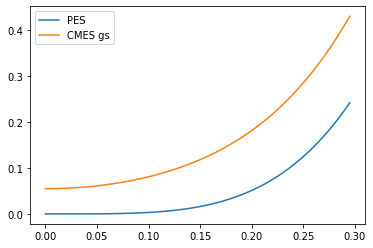

In [22]:
# V= bx^4
x1 = np.arange(0.0, 0.3, 0.005)
print(x1)
a=0
b=32

lines = []
f0 = 0.0
f1 = 0.0
f2 = 3.47 / 1.1
E_gs=[]
for xx in x1:
    e_gs, c_gs, f0, error0 = fdm_constrained_dense_solver(a, b, xx, state=0, init_f=0.0)
    E_gs.append(e_gs)
    lines.append([xx, e_gs, f0, error0])
    print(lines[-1])
E_gs=np.array(E_gs)
E_PES=V(x1,a,b,0)

plt.plot(x1, E_PES, label='PES')
plt.plot(x1, E_gs, label='CMES gs')
plt.legend()
plt.show()


In [7]:
with open('/Users/yiwenwang/Desktop/Yiwen Wang/CMES/Double well/python/doublewell_potential_gs_and_ex_001_0_036.txt', 'w') as f:
    for i in range(len(lines) - 1):
        line = lines[len(lines) - 1 - i]
        f.writelines([str(-line[0]), ' ', str(line[1]), ' ', str(line[2]), ' ',
                      str(-line[3]), ' ', str(-line[4]), ' ', str(line[5]), ' ',
                      str(-line[6]), ' ', str(-line[7]), ' ', str(line[8]), '\n'])
    for i in range(len(lines)):
        line = lines[i]
        f.writelines([str(line[0]), ' ', str(line[1]), ' ', str(line[2]), ' ',
                      str(line[3]), ' ', str(line[4]), ' ', str(line[5]), ' ',
                      str(line[6]), ' ', str(line[7]), ' ', str(line[8]), '\n'])

NameError: name 'lines' is not defined

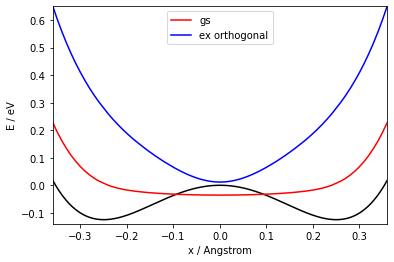

In [8]:
plt.figure()
xx = np.linspace(-0.36, 0.36, num=720)
v_plt = -4 * xx ** 2 + 32 * xx ** 4
plt.plot(xx, v_plt, 'k-')
with open('/Users/yiwenwang/Desktop/Yiwen Wang/CMES/Double well/python/doublewell_potential_gs_and_ex_001_0_036.txt', 'r') as f:
    CMES_data = np.loadtxt(f)
    x = CMES_data[:, 0]
    e_gs = CMES_data[:, 1]
    e_ex = CMES_data[:, 2]
    plt.plot(x, e_gs, 'r-', label='gs')
    plt.plot(x, e_ex, 'b-', label='ex orthogonal')

plt.xlim(-0.36, 0.36)
plt.ylim(-0.14, 0.65)
plt.xlabel('x / Angstrom')
plt.ylabel('E / eV')
plt.legend()
plt.show()

In [53]:
# CMES: a=8, b=32
x1 = np.arange(0.0, 0.41, 0.01)
print(x1)
a=8
b=32

lines = []

for xx in x1:
    e_gs, c_gs, f0, error0 = fdm_constrained_dense_solver(a, b, xx, state=0, init_f=0.0)
    e_ex, f1, f2, error1, error2 = fdm_constrained_dense_solver(a, b, xx, state=1, gs_coef=c_gs, init_f=[0.0, 5.0])
    lines.append([xx, e_gs, e_ex, f0, f1, f2, error0, error1, error2])
    print(lines[-1])
    
    

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4 ]
[0.0, 0.134999003874668, 0.4151039523259807, 0.0, 0.0, 5.0, -5.610570935593749e-16, -4.588421647633869e-14, 1.257286794571351e-32]
[0.01, 0.13593832347244625, 0.4163022359094287, -0.1879168696675837, -0.21380384748359293, 5.000000001133996, -5.830405602758049e-15, 6.3538410643992904e-12, 1.7146577552335334e-12]
[0.02, 0.13875946046861432, 0.41989926878797507, -0.37646957936032993, -0.4281460150575429, 5.000000004680173, -3.094521167090747e-12, -1.4190038033490282e-15, 6.815073156733582e-12]
[0.03, 0.14347196133487805, 0.42590162268162485, -0.5662963455907098, -0.6435683797469529, 5.000000010797722, -1.1536746558071798e-10, 2.5960206206931957e-12, 1.5172496392578792e-11]
[0.04, 0.15009177654382228, 0.43432033433839556, -0.7580400811237984, -0.8606198563232278, 5.000000019864716, -5

In [54]:
with open('/Users/yiwenwang/Desktop/Yiwen Wang/CMES/Double well/python/a_8_b_32_doublewell_potential_gs_and_ex_001_0_040.txt', 'w') as f:
    for i in range(len(lines) - 1):
        line = lines[len(lines) - 1 - i]
        f.writelines([str(-line[0]), ' ', str(line[1]), ' ', str(line[2]), ' ',
                      str(-line[3]), ' ', str(-line[4]), ' ', str(line[5]), ' ',
                      str(-line[6]), ' ', str(-line[7]), ' ', str(line[8]), '\n'])
    for i in range(len(lines)):
        line = lines[i]
        f.writelines([str(line[0]), ' ', str(line[1]), ' ', str(line[2]), ' ',
                      str(line[3]), ' ', str(line[4]), ' ', str(line[5]), ' ',
                      str(line[6]), ' ', str(line[7]), ' ', str(line[8]), '\n'])

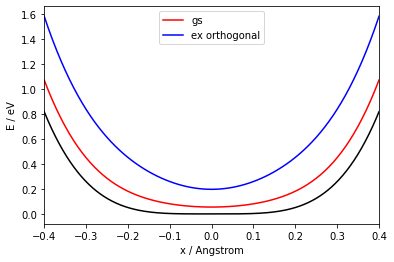

In [49]:
# a=0, b=32
plt.figure()
xx = np.linspace(-0.4, 0.4, num=720)
v_plt = V(xx, 0, 32, 0)
plt.plot(xx, v_plt, 'k-')
with open('/Users/yiwenwang/Desktop/Yiwen Wang/CMES/Double well/python/a_0_b_32_doublewell_potential_gs_and_ex_001_0_040.txt', 'r') as f:
    CMES_data = np.loadtxt(f)
    x = CMES_data[:, 0]
    e_gs = CMES_data[:, 1]
    e_ex = CMES_data[:, 2]
    plt.plot(x, e_gs, 'r-', label='gs')
    plt.plot(x, e_ex, 'b-', label='ex orthogonal')

plt.xlim(-0.4, 0.4)
# plt.ylim(-0.6, 0)
plt.xlabel('x / Angstrom')
plt.ylabel('E / eV')
plt.legend()
plt.show()

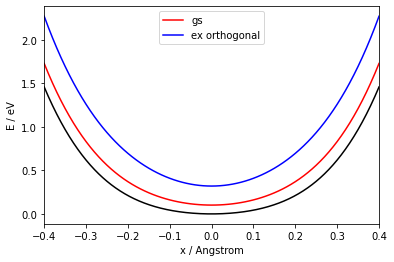

In [52]:
# a=4, b=32
plt.figure()
xx = np.linspace(-0.4, 0.4, num=720)
v_plt = V(xx, 4, 32, 0)
plt.plot(xx, v_plt, 'k-')
with open('/Users/yiwenwang/Desktop/Yiwen Wang/CMES/Double well/python/a_4_b_32_doublewell_potential_gs_and_ex_001_0_040.txt', 'r') as f:
    CMES_data = np.loadtxt(f)
    x = CMES_data[:, 0]
    e_gs = CMES_data[:, 1]
    e_ex = CMES_data[:, 2]
    plt.plot(x, e_gs, 'r-', label='gs')
    plt.plot(x, e_ex, 'b-', label='ex orthogonal')

plt.xlim(-0.4, 0.4)
# plt.ylim(-0.6, 0)
plt.xlabel('x / Angstrom')
plt.ylabel('E / eV')
plt.legend()
plt.show()

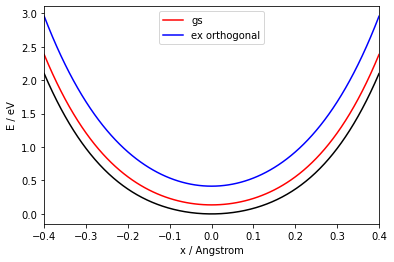

In [56]:
# a=8, b=32
plt.figure()
xx = np.linspace(-0.4, 0.4, num=720)
v_plt = V(xx, 8, 32, 0)
plt.plot(xx, v_plt, 'k-')
with open('/Users/yiwenwang/Desktop/Yiwen Wang/CMES/Double well/python/a_8_b_32_doublewell_potential_gs_and_ex_001_0_040.txt', 'r') as f:
    CMES_data = np.loadtxt(f)
    x = CMES_data[:, 0]
    e_gs = CMES_data[:, 1]
    e_ex = CMES_data[:, 2]
    plt.plot(x, e_gs, 'r-', label='gs')
    plt.plot(x, e_ex, 'b-', label='ex orthogonal')

plt.xlim(-0.4, 0.4)
# plt.ylim(-0.6, 0)
plt.xlabel('x / Angstrom')
plt.ylabel('E / eV')
plt.legend()
plt.show()

In [9]:
# numerically solve the quantum references

def doublewell_level(a, b,nstates=5, ntrial=50, eps=1e-3,
               bound=(-2, 2), mass=1.0, plt_xlim=(-1, 1),
                debug=False):
    """a : eV / Angstrom^2; b : eV / Angstrom^4; mass : u"""
    nstates = int(nstates)
    ntrial = int(ntrial)
    eps = abs(eps)
    f=0
    if debug:
        print(f'{a=} eV/Angstrom^2, {b=} eV/Angstrom^4, {f=} eV/Angstrom')
    # boundary
    if bound[1] < bound[0]:
        left = bound[1]
        right = bound[0]
    else:
        left = bound[0]
        right = bound[1]

    # number of grids
    N = int((right - left) / eps) + 1
    # make sure in the end there are 2**k + 1 points
    N = int(2 ** int(np.ceil(np.log2(N))) + 1)
    if debug:
        print(f'{N=}')
    # distance between points
    dx = float(right - left) / (N - 1)

    # x grids
    x = np.linspace(left, right, num=N)
    
    diagonals = np.zeros((3, N))
    # off-diag
    diagonals[0,:] = -0.5 * hbar ** 2 * 1e20 / e / (mass * u) / dx**2
    # diag
    diagonals[1,:] = float(1) * hbar ** 2 * 1e20 / e / (mass * u) / dx**2
    # potential part
    for i in range(N):
        diagonals[1, i] += V(x[i], a, b, f)
    # in the end this is a symmetric matrix
    diagonals[2, 1:] = diagonals[0, :-1]
    H = spdiags(diagonals, [-1, 0, 1], N, N, format='csc')
    # solve Hc = ec
    xx = np.linspace(left, right, num=int((right - left) / 1e-3)+1)
    v_plt = a * xx ** 2 + b * xx ** 4
    v_f_plt = v_plt + f * xx

    ene, coef = eigsh(H, k=ntrial, sigma=v_f_plt.min(), which='LM')
    true_e=ene[0:nstates]

    idx = np.argpartition(true_e, range(nstates))
    true_e=true_e[idx]

    return true_e

In [14]:
# calculate the zero-temperature frequencies on CMESs

def doublewell_hessian(a,b):
    E_gs=[]
    E_orth=[]
    mass=1.0
    # finite difference coefficient
    coeff=np.array([-1/560,8/315,-1/5,8/5,-205/72,8/5,-1/5,8/315,-1/560])
    dx=0.01
    x_=np.arange(-0.04,0.041,0.01)
    
    e_level=doublewell_level(a,b)*e/(h*c)*1e-2
    E10=e_level[1]-e_level[0]
    E21=e_level[2]-e_level[1]
    print(e_level)
    for xx in x_:
        e_gs, c_gs, f0, error0 = fdm_constrained_dense_solver(a, b, xx, state=0, init_f=0.0)
        e_ex, f1, f2, error1, error2 = fdm_constrained_dense_solver(a, b, xx, state=1, gs_coef=c_gs, index=0, init_f=[0.0, 5.0])
        E_gs.append(e_gs)
        E_orth.append(e_ex)

    E_gs=np.array(E_gs)    
    E_orth=np.array(E_orth)
    k_gs=sum(np.multiply(E_gs,coeff))/(dx**2)
    k_orth=sum(np.multiply(E_orth,coeff))/(dx**2)
    freq_gs=1/(2*math.pi)*math.sqrt(k_gs*e*1e20/(mass*u))/c*1e-2
    freq_orth=1/(2*math.pi)*math.sqrt(k_orth*e*1e20/(mass*u))/c*1e-2  # in the unit of cm-1

    return [a,b,freq_gs,freq_orth,E10,E21]



In [15]:
a=-4
b=32
lines=[]
line=doublewell_hessian(a,b)
lines.append(line)
print(lines[-1])

[-287.92932522   93.65734573 1337.8022501  2650.19310339 4217.68395785]
[-4, 32, 419.58609815954355, 1833.7875234467574, 381.5866709519984, 1244.1449043724215]


In [16]:
a=4
b=32
lines=[]
line=doublewell_hessian(a,b)
lines.append(line)
print(lines[-1])

[ 818.4532968  2583.00613679 4568.86209024 6725.14722424 9024.27056418]
[4, 32, 1766.016897841847, 2188.7648323184812, 1764.5528399896657, 1985.855953445538]


In [18]:
a=0
b=32
line=doublewell_hessian(a,b)
lines.append(line)
print(lines[-1])

[ 443.859232   1590.50903547 3120.87631776 4874.34499321 6806.96236238]
[0, 32, 1152.6779656031365, 1848.4227628500676, 1146.6498034782423, 1530.3672822825592]


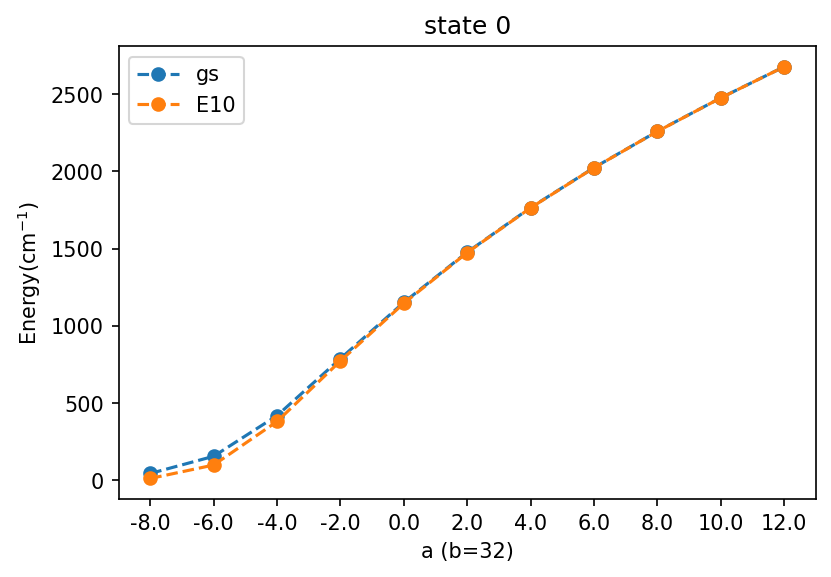

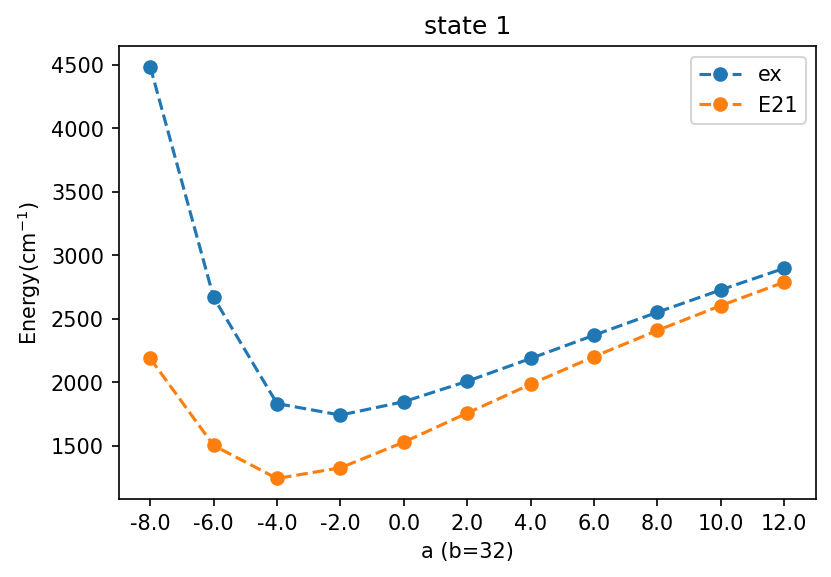

In [19]:
with open('/Users/yiwenwang/Desktop/Yiwen Wang/CMES/Double well/python/hessian_b_32_a_-8_-4_gs_ex_E01_E12.txt', 'r') as f:
    data=np.loadtxt(f)
    
xaxis=np.arange(1,4.1,dtype=int)
names=['a=-8\nb=32','a=-4\nb=32','a=0\nb=32','a=4\nb=32']
a=data[:,0]
b=data[:,1]
e_gs=data[:,2]
e_orth=data[:,3]
E10=data[:,4]
E21=data[:,5]


with open('/Users/yiwenwang/Desktop/Yiwen Wang/CMES/Double well/python/hessian_b_32_a_0_4_gs_ex_ex2_orth_E01_E12_E32.txt', 'r') as f:
    data=np.loadtxt(f)
    
a=np.concatenate((a,data[:,0]))
a_ex=data[:,0]
b=np.concatenate((b,data[:,1]))
e_gs=np.concatenate((e_gs,data[:,2]))
e_ex=data[:,3]
e_ex2=data[:,4]
e_orth=np.concatenate((e_orth,data[:,5]))
E10=np.concatenate((E10,data[:,6]))
E21=np.concatenate((E21,data[:,7]))
E32=data[:,8]

names=np.copy(a)
names.astype(str)

plt.figure(dpi=150)
plt.title('state 0')
plt.plot(a,e_gs,linestyle='--',marker='o',label='gs')
plt.plot(a,E10,linestyle='--',marker='o',label='E10')
plt.legend()
plt.xticks(a,names)
plt.xlabel('a (b=32)')
plt.ylabel('Energy(cm$^{-1}$)')
plt.show()

plt.figure(dpi=150)
plt.title('state 1')
plt.plot(a,e_orth,linestyle='--',marker='o',label='ex')
plt.plot(a,E21,linestyle='--',marker='o',label='E21')
plt.legend()
plt.xticks(a,names)
plt.xlabel('a (b=32)')
plt.ylabel('Energy(cm$^{-1}$)')
plt.show()